In [1]:
from absl import logging
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import fnmatch
from collections import defaultdict
import tqdm
import hashlib
import tensorflow as tf

## Audi dataset details

The bounding box dataset contains 11,754 frames. Each frame has an annotated bounding box label.

All frames are grouped in 18 different scenes with each scene contained in its corresponding folder. Scene folder names are in the 'YYYYMMDD_hhmmss' format. They represent the date and time of the recording. Each scene is further divided into four folders as mentioned below. For this project, we will be using data from two folders namely 'camera' and 'label3D'.

- 'camera': input images and json info files
- 'lidar': input 3D point clouds
- 'label': annotated label images
- 'label3D': annotated 3D bounding boxes 

Each of these folders are further divided depending on the camera from which the data was recorded. There are six
cameras available in the vehicle, therefore, the following are the camera folders:

- 'cam_front_center'
- 'cam_front_left'
- 'cam_front_right'
- 'cam_side_left'
- 'cam_side_right'
- 'cam_rear_center'

Lastly, each of these folders contains the corresponding item for each frame.
These are the filename formats for the item of a single frame:

- input RGB image: YYMMDDDDhhmmss_camera_[frontcenter|frontleft|frontright|sideleft|sideright|rearcenter]_[ID].png
- 3D Bounding Box: YYMMDDDDhhmmss_label3D_[frontcenter|frontleft|frontright|sideleft|sideright|rearcenter]_[ID].json

For example, a frame with ID 1617 from a scene recorded on 2018-08-07 14:50:28 from the front center camera would be have the following items in these locations:

- input RGB image  : 20180807_145028/camera/cam_front_center/20180807145028_camera_frontcenter_000001617.png
- 3D Bounding Box  : 20180807_145028/label3D/cam_front_center/20180807145028_label3D_frontcenter_000001617.json

In [3]:
cur_dir = os.getcwd()
dictFiles = defaultdict(list)
# Get all the filepaths for json and respective image files
for dirpath, dirname, filenames in os.walk('./data/Audi_dataset'):
    for file in filenames:
        if fnmatch.fnmatch(file, '*_label3D_*.json'):
            key = file.split('_')[3].split('.')[0].lstrip('0')
            filepath = dirpath + '/' + file
            dictFiles[key].append(filepath.lstrip('.'))
        if fnmatch.fnmatch(file, '*_camera_*.png'):
            key = file.split('_')[3].split('.')[0].lstrip('0')
            filepath = dirpath + '/' + file
            dictFiles[key].append(filepath.lstrip('.'))
# DataFrame with all the filepaths for json and respective image files
dataset = pd.DataFrame([(k, v[0],v[1]) for k, v in dictFiles.items()], columns = ['id','jsonFile','imageFile'])

dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11754 entries, 0 to 11753
Data columns (total 3 columns):
id           11754 non-null object
jsonFile     11754 non-null object
imageFile    11754 non-null object
dtypes: object(3)
memory usage: 275.6+ KB


,id,jsonFile,imageFile
0,122788,/data/Audi_dataset/20181204_135952/label3D/cam...,/data/Audi_dataset/20181204_135952/camera/cam_...
1,80971,/data/Audi_dataset/20181204_135952/label3D/cam...,/data/Audi_dataset/20181204_135952/camera/cam_...
2,87534,/data/Audi_dataset/20181204_135952/label3D/cam...,/data/Audi_dataset/20181204_135952/camera/cam_...
3,113606,/data/Audi_dataset/20181204_135952/label3D/cam...,/data/Audi_dataset/20181204_135952/camera/cam_...
4,36780,/data/Audi_dataset/20181204_135952/label3D/cam...,/data/Audi_dataset/20181204_135952/camera/cam_...


### For object annotations, we will be using the '2d_bbox' details and its corresponding 'class' labels provided in the json file for each image.

In [7]:
df = pd.DataFrame()
# Read the json files to get the 2D and 3D boxes details 
for key, row in tqdm.tqdm(dataset.iterrows()):
    d = pd.read_json(cur_dir+row['jsonFile'])
    height, width = plt.imread(cur_dir + row['imageFile']).shape[:2]
    d = d.loc[['2d_bbox','class']].transpose()
    d['id'] = row['id']
    d['width'] = width
    d['height'] = height
    df = pd.concat([df,d],sort=True)
    
audiDf = pd.merge(dataset, df, on='id', how='inner')
audiDf['x1'] = audiDf['2d_bbox'].str[0] #2d_bbox_left
audiDf['y1'] = audiDf['2d_bbox'].str[1] #2d_bbox_top
audiDf['x2'] = audiDf['2d_bbox'].str[2] #2d_bbox_right
audiDf['y2'] = audiDf['2d_bbox'].str[3] #2d_bbox_bottom

11754it [23:11,  8.01it/s]


In [8]:
#audiDf.to_csv('data/audi_dataset.csv')

In [2]:
audiDf = pd.read_csv('data/audi_dataset.csv', index_col=0)

In [3]:
audiDf.head()

,id,jsonFile,imageFile,2d_bbox,class,height,width,x1,y1,x2,y2
0,122788,/data/Audi_dataset/20181204_135952/label3D/cam...,/data/Audi_dataset/20181204_135952/camera/cam_...,"[1546.853, 731.8743, 2600.568, 1212.974]",Car,1208,1920,1546.8530,731.8743,2600.5680,1212.9740
1,80971,/data/Audi_dataset/20181204_135952/label3D/cam...,/data/Audi_dataset/20181204_135952/camera/cam_...,"[100.1629, 584.1248, 373.4479, 694.48]",Truck,1208,1920,100.1629,584.1248,373.4479,694.4800
2,80971,/data/Audi_dataset/20181204_135952/label3D/cam...,/data/Audi_dataset/20181204_135952/camera/cam_...,"[1068.235, 330.0452, 1578.198, 918.1988]",Truck,1208,1920,1068.2350,330.0452,1578.1980,918.1988
3,87534,/data/Audi_dataset/20181204_135952/label3D/cam...,/data/Audi_dataset/20181204_135952/camera/cam_...,"[1164.702, 511.1872, 1546.12, 868.445]",Truck,1208,1920,1164.7020,511.1872,1546.1200,868.4450
4,87534,/data/Audi_dataset/20181204_135952/label3D/cam...,/data/Audi_dataset/20181204_135952/camera/cam_...,"[-672.8669, 446.4352, 334.3822, 909.3825]",Truck,1208,1920,-672.8669,446.4352,334.3822,909.3825


### Check the annotations for one of the image

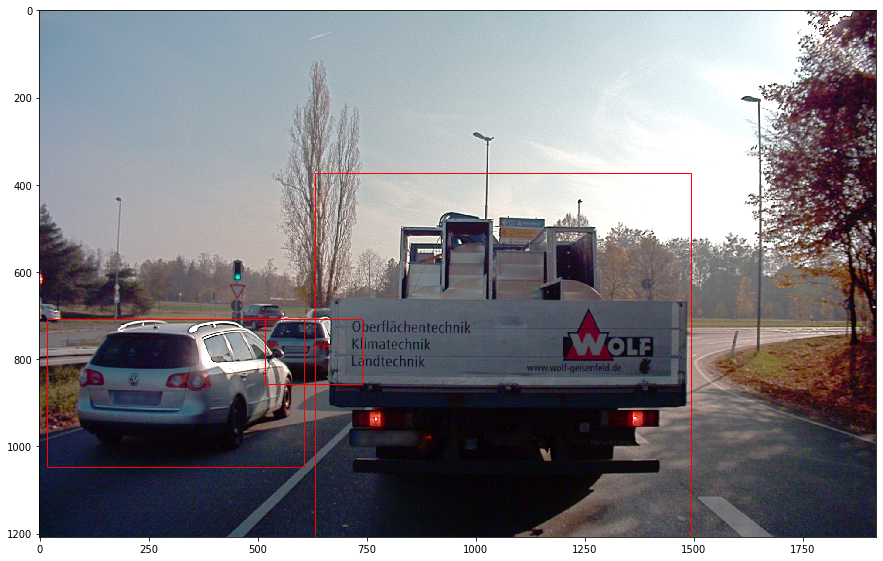

In [11]:
cur_dir = os.getcwd()
s = audiDf[audiDf.imageFile.str.contains('20181107133258_camera_frontcenter_000000484')]
img = plt.imread(cur_dir+s['imageFile'].iloc[0])
figure, ax = plt.subplots(1, figsize=(15,15))
for key, row in s.iterrows():
    topleft_x = row['x1']
    topleft_y = row['y1']
    bottom_right_x = row['x2']
    bottom_right_y = row['y2']
    rect = plt.Rectangle((topleft_x,topleft_y),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
                         edgecolor='r', facecolor="none")
    _ = ax.add_patch(rect)
_ = plt.imshow(img)

### Total count of labels in whole dataset

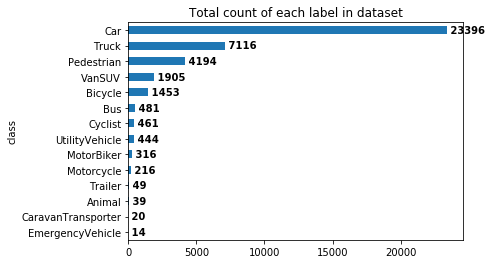

In [12]:
s = audiDf.groupby(['class']).size().sort_values(ascending=True)
ax = s.plot(kind='barh')
[ax.text(v, i, " "+str(v), va='center', fontweight='bold') for i, v in enumerate(s)];
_ = plt.title('Total count of each label in dataset')

### The audi dataset is split into training, validation and testing set

In [4]:
train_dataset, test_dataset, val_dataset = np.split(dataset.sample(frac=1), 
                                                    [int(.7*len(dataset)), int(.8*len(dataset))])
train_dataset.shape, test_dataset.shape, val_dataset.shape

((8227, 3), (1176, 3), (2351, 3))

### audi_convert() method is created for converting the audi data annotations to tfrecord format, so that this tfrecord data can be given directly to the YOLO model for training and validation.

### build_example() method is iterrating over each row in audi dataframe and converting it to tf.example format which is later serialized in audi_convert() method.

In [13]:
classesFile = './data/classes.txt'

def audi_convert(data):
    class_map = {name: idx for idx, name in enumerate(
        open(classesFile).read().splitlines())}
    logging.info("Class mapping loaded: %s", class_map)

    writer = tf.io.TFRecordWriter(output_file)

    for key, row in tqdm.tqdm(data.iterrows()):
        tf_example = build_example(row, class_map)
        writer.write(tf_example.SerializeToString())
    writer.close()
    logging.info("Done")

In [14]:
def build_example(row, class_map):
    d = pd.read_json(cur_dir + row['jsonFile'])
    d = d.loc[['2d_bbox','class']].transpose()    
    img_path = cur_dir + row['imageFile']
    height, width = plt.imread(img_path).shape[:2]
    img_raw = open(img_path, 'rb').read()
    key = hashlib.sha256(img_raw).hexdigest()

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
   
    for k, val in d.iterrows():
        x1 = val['2d_bbox'][0] if val['2d_bbox'][0] > 0 else 0
        y1 = val['2d_bbox'][1] if val['2d_bbox'][1] > 0 else 0
        x2 = val['2d_bbox'][2] if val['2d_bbox'][2] > 0 else 0
        y2 = val['2d_bbox'][3] if val['2d_bbox'][3] > 0 else 0
        
        xminval = (float(x1) / width) if (float(x1) / width) < 1 else 1
        yminval = (float(y1) / height) if (float(y1) / height) < 1 else 1
        xmaxval = (float(x2) / width) if (float(x2) / width) < 1 else 1
        ymaxval = (float(y2) / height) if (float(y2) / height) < 1 else 1
        
        xmin.append(xminval)
        ymin.append(yminval)
        xmax.append(xmaxval)
        ymax.append(ymaxval)
        classes_text.append(val['class'].encode('utf8'))
        classes.append(class_map[val['class']])

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            row['imageFile'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            row['imageFile'].encode('utf8')])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['png'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }))

    return example

In [19]:
output_file = './data/audi_train.tfrecord'
audi_convert(train_dataset)

8227it [31:53,  4.35it/s]


In [15]:
output_file = './data/audi_val.tfrecord'
audi_convert(val_dataset)

2351it [04:29,  8.94it/s]


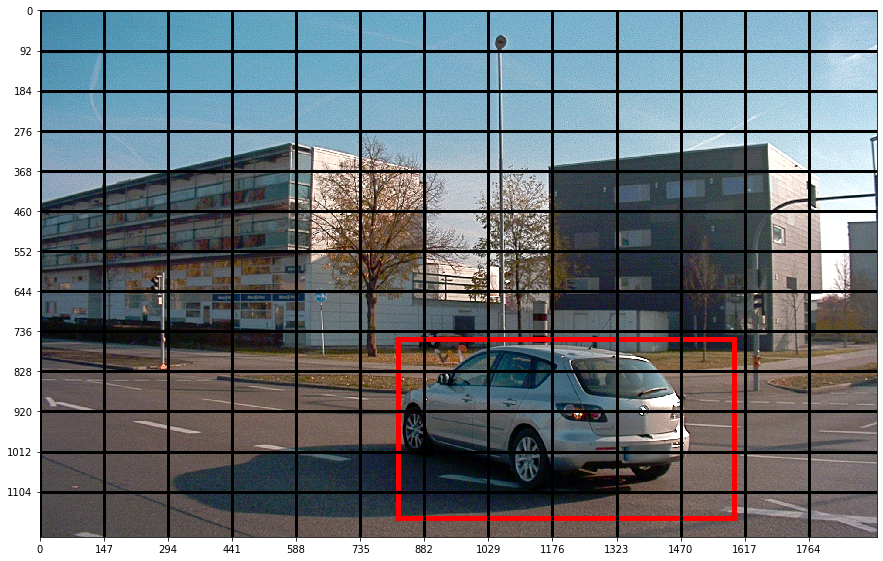

In [2]:
audiDf = pd.read_csv('data/audi_dataset.csv', index_col=0)
cur_dir = os.getcwd()
s = audiDf[audiDf.imageFile.str.contains('20181107132300_camera_frontcenter_000002892')]
img = plt.imread(cur_dir+s['imageFile'].iloc[0])
figure, ax = plt.subplots(1, figsize=(15,15))
for key, row in s.iterrows():
    topleft_x = row['x1']
    topleft_y = row['y1']
    bottom_right_x = row['x2']
    bottom_right_y = row['y2']
    rect1 = plt.Rectangle((topleft_x,topleft_y),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
                         edgecolor='r', facecolor='none', linewidth=5)
    #rect2 = plt.Rectangle((topleft_x-30,topleft_y+80),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
    #                     edgecolor='r', facecolor='none', linewidth=5)
    #rect3 = plt.Rectangle((topleft_x+50,topleft_y-30),(bottom_right_x-topleft_x),(bottom_right_y-topleft_y), 
    #                     edgecolor='r', facecolor='none', linewidth=5)
    _ = ax.add_patch(rect1)
    #_ = ax.add_patch(rect2)
    #_ = ax.add_patch(rect3)
    ax.grid(which='major', axis='both', linestyle='-', color='black', linewidth=3)
_ = plt.xticks((0,147,294,441,588,735,882,1029,1176,1323,1470,1617,1764))
_ = plt.yticks((0,92,184,276,368,460,552,644,736,828,920,1012,1104))
_ = plt.imshow(img)

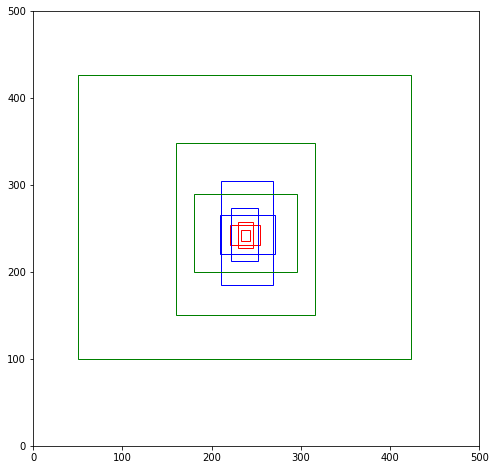

In [3]:
#anchors = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
#                         (59, 119), (116, 90), (156, 198), (373, 326)]

#from matplotlib.patches import Rectangle 
fig, ax = plt.subplots(figsize=(8,8))
rect1 = plt.Rectangle((233,235),(10),(13) , edgecolor='r', facecolor='none')
rect2 = plt.Rectangle((230,227),(16),(30) , edgecolor='r', facecolor='none')
rect3 = plt.Rectangle((221,231),(33),(23) , edgecolor='r', facecolor='none')
rect4 = plt.Rectangle((222,212),(30),(61) , edgecolor='b', facecolor='none')
rect5 = plt.Rectangle((209,220),(62),(45) , edgecolor='b', facecolor='none')
rect6 = plt.Rectangle((210,185),(59),(119), edgecolor='b', facecolor='none')
rect7 = plt.Rectangle((180,200),(116),(90), edgecolor='g', facecolor='none')
rect8 = plt.Rectangle((160,150),(156),(198),edgecolor='g', facecolor='none')
rect9 = plt.Rectangle((50,100),(373),(326), edgecolor='g', facecolor='none')

_ = ax.add_patch(rect1)
_ = ax.add_patch(rect2)
_ = ax.add_patch(rect3)
_ = ax.add_patch(rect4)
_ = ax.add_patch(rect5)
_ = ax.add_patch(rect6)
_ = ax.add_patch(rect7)
_ = ax.add_patch(rect8)
_ = ax.add_patch(rect9)

ax.set_xlim([0, 500])
ax.set_ylim([0, 500])
_ = plt.show()